In [1]:
import sys
import os 
import seaborn as sns
import graphviz
import pydotplus 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import scipy as sp
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import ExtraTreesClassifier #导入ExtraTrees

In [3]:
original_train = pd.read_json('train_bonus.json')
original_test = pd.read_json('test_bonus.json')

# Cross-Validation

In [4]:
def cv_score_manual(DicisionTreeModel,X,y):    
    kf = KFold(n_splits = 10)
    i = 1
    scores = []
    for train_index, valid_index in kf.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        DicisionTreeModel.fit(X_train,y_train)
        scores.append(DicisionTreeModel.score(X_valid,y_valid))
    return np.array(scores).mean()

In [5]:
def cv_score(clr,X,y):
    score = cross_val_score(clr,X,y,cv=5)
    return score.mean()

In [6]:
def haversine(df):
    lat1 = df['latitude']
    lat2 = 40.785091
    lon1 = df['longitude']
    lon2 = -73.968285
    dlat = np.deg2rad(np.fabs(lat2-lat1))
    dlon = np.deg2rad(np.fabs(lon2-lon1))
    a = np.sin(dlat/2)**2 + np.cos(np.deg2rad(lat1))*np.cos(np.deg2rad(lat2))*np.sin(dlon/2)**2
    c =2 * np.arcsin(np.sqrt(a))
    Earth_Radius = 6371
    return c * Earth_Radius * 1000

# Prepare

In [7]:
train = original_train.drop(columns = {'rec_id','created','building_id','description','display_address','manager_id','features','photos','street_address','clean_feat'})
train['price_per_bedroom'] = train['price']/(train['bedrooms']+1)
train['price_per_bathroom'] = train['price']/(train['bathrooms']+1)
# train['distance'] = haversine(train)
X = train.drop(columns = {'interest_level'})
y = train['interest_level']
X = X.reset_index(drop = True)
y = y.reset_index(drop = True)

In [8]:
test = original_test.drop(columns = {'rec_id','created','building_id','description','display_address','manager_id','features','photos','street_address','clean_feat'})
test['price_per_bedroom'] = test['price']/(test['bedrooms']+1)
test['price_per_bathroom'] = test['price']/(test['bathrooms']+1)
test['diff_rooms'] = test['bedrooms']-test['bathrooms']
# test['distance'] = haversine(test)
X_test = test.reset_index(drop = True)

In [9]:
X.columns[0:]

Index(['bathrooms', 'bedrooms', 'latitude', 'listing_id', 'longitude', 'price',
       'diff_rooms', 'desc_apartment', 'desc_appliances', 'desc_bedroom',
       'desc_building', 'desc_floors', 'desc_hardwood', 'desc_kitchen',
       'desc_renovated', 'desc_space', 'desc_website_redacted',
       'ft_catsallowed', 'ft_dishwasher', 'ft_dogsallowed', 'ft_doorman',
       'ft_elevator', 'ft_fitnesscenter', 'ft_hardwoodfloors',
       'ft_laundryinbuilding', 'ft_laundryinunit', 'ft_nofee',
       'manager_id_num', 'building_id_num', 'photo_num', 'distance_subway',
       'price_per_bedroom', 'price_per_bathroom'],
      dtype='object')

# Feature Selection

## 1. Extra-Trees

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif,mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import pearsonr
from minepy import MINE

In [11]:
def extra_tree(X,y,k):
    model = ExtraTreesClassifier() #设置ExtraTrees
    model.fit(X, y)
    temp = np.array(model.feature_importances_)
    temp_index = np.argpartition(temp, -k)[-k:]
    X_new = X.iloc[:,temp_index]
    return X_new


## 2. SelectKBest F-score

In [12]:
def f_score(X,X_test,y,k):
    tempindex = SelectKBest(f_classif,k=k).fit(X,y).get_support(indices = True)
    X_new = X.iloc[:,tempindex]
    X_test_new = X_test.iloc[:,tempindex]
    return X_new,X_test_new

## 3. SelectKBest Mutual Information 

In [13]:
def MI(X,X_test,y,k):              # best
    tempindex = SelectKBest(mutual_info_classif,k=k).fit(X,y).get_support(indices = True)
    X_new = X.iloc[:,tempindex]
    X_test_new = X_test.iloc[:,tempindex]
    return X_new,X_test_new

# Output Result

In [14]:
def to_result_format(X):
    res = pd.DataFrame(y_test,columns=['high', 'low', 'medium'])
    temp = res['low']
    res = res.drop(columns = {'low'})
    res.insert(2,'low',temp)
    res.insert
    res.insert(0,'listing_id',X['listing_id'])
    res.to_csv('submission.csv', index = None)
    return res

# Dicision Tree First Time

In [15]:
DecisionTreeModel_1 = DecisionTreeClassifier()
DecisionTreeModel_1.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [16]:
y_test = DecisionTreeModel_1.predict_proba(X_test)
res = to_result_format(X_test)
cv_score(DecisionTreeModel_1,X,y)

0.6512554340703851

# Decision Tree Second Time

In [17]:
DecisionTreeModel_2 = DecisionTreeClassifier(min_impurity_decrease=0.0007,max_leaf_nodes=80, min_samples_leaf=5, criterion='entropy')
DecisionTreeModel_2.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=80,
                       min_impurity_decrease=0.0007, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [18]:
y_test = DecisionTreeModel_2.predict_proba(X_test)
res = to_result_format(X_test)
cv_score(DecisionTreeModel_2,X,y)

0.7148577974640851

# Decision Tree with PCA

In [19]:
x_all = pd.concat([X,X_test],sort=False)
X_pca = PCA(n_components=5).fit_transform(x_all)
X_train_pca = X_pca[:49165]
X_test_pca = X_pca[49165:]

In [20]:
DecisionTreeModel_PCA = DecisionTreeClassifier(min_impurity_decrease=0.0007,max_leaf_nodes=80, min_samples_leaf=5, criterion='entropy')
DecisionTreeModel_PCA.fit(X_train_pca,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=80,
                       min_impurity_decrease=0.0007, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [21]:
y_test = DecisionTreeModel_PCA.predict_proba(X_test_pca)
res = to_result_format(X_test)
cv_score(DecisionTreeModel_PCA,X_train_pca,y)

0.7052983767602996

# Visualization

In [22]:
feature_name = X.columns[0:]
target_name = np.unique(y)

In [23]:
from IPython.display import Image  
dot_data = tree.export_graphviz(DecisionTreeModel_2, out_file=None, 
                         feature_names=feature_name,  
                         class_names=target_name,  
                         filled=True, rounded=True,  
                         special_characters=True)  

In [24]:
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())
graph.write_png("pic_2.png")

True

# Confusion Matrix

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y)

In [26]:
model = DecisionTreeClassifier(min_impurity_decrease=0.0007,max_leaf_nodes=80, min_samples_leaf=5, criterion='entropy')
model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=80,
                       min_impurity_decrease=0.0007, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [27]:
y_pred = model.predict(X_valid)

In [28]:
def cm_plot(y_valid,y_pred):
    cm = confusion_matrix(y_valid, y_pred, labels = ['high','low','medium'])
    cm = pd.DataFrame(cm,columns=['high','low','medium'],index = ['high','low','medium'])
    plt.title('Confusion Matrix',fontsize=18)
    ax = sns.heatmap(cm,annot=True,cmap='Blues',fmt='.20g',linewidths = 0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted Label',fontsize=12)
    plt.ylabel('True Label',fontsize=12)
    plt.savefig('cm.png',dpi=800)

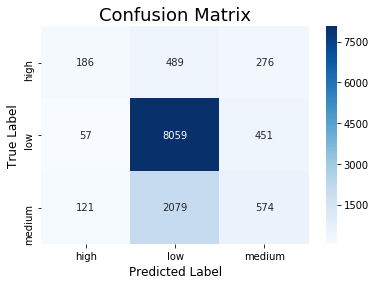

In [29]:
cm_plot(y_valid,y_pred)